<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** José Manuel Haces López y Rafael Juarez Badillo Chávez

**Fecha:** 16 de Febrero del 2023.

**Expediente**: 734759 y 733240
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/JManuelHaces/Tarea3_Haces_Juarez

# Tarea 3: Clase 7

## Enunciado de la Tarea 
- Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import statsmodels as st
import numpy as np
from statsmodels.tsa.seasonal import MSTL
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import boxcox, yeojohnson
import itertools
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore")


Código de solución estudiante 1

In [2]:
# Código de solución estudiante 1



Código de solución estudiante 2

In [3]:
import pandas as pd

url = 'https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true'

df = pd.read_excel(url)

In [4]:
df['date'] = df.apply(lambda x: x['date'] + pd.Timedelta(x['hour'], 'h'), axis = 1)
pd.to_datetime(df['date'])
df.drop(columns=['Unnamed: 0', 'year', 'month', 'day', 'hour'], inplace=True)
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df.rename(columns={'Energy (kWh)':'y'}, inplace=True)
df.head(3)

,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),y
date,,,,,,
1990-01-01 06:00:00,234,503,78,12.1406,9.7,498.632
1990-01-01 07:00:00,448,723,91,13.3250,10.1,720.409
1990-01-01 08:00:00,699,959,71,13.3094,9.3,946.154


In [5]:
# Código de solución estudiante 2
class TimeSeriesAnalyzer:

    def __init__(self, data):
        self.data = data

    def defineTimeSeries(self):
        timeseries = df['y'].copy()
        timeseries =pd.DataFrame(timeseries)
        timeseries = timeseries.resample('M').mean()
        self.timeseries = timeseries
        return self.timeseries

    def plot_acf_pacf(self, diff=0, wantSeasonal=True,wantOberved=True,wantNoSeasonal=True, whatSeasonal='',kwargs={'lags': 40}):
        if wantSeasonal == True:
            if wantOberved == True:
                if wantNoSeasonal == True:
                    seasonality_data = self.res2.observed - self.res2.seasonal['seasonal_6'] - self.res2.seasonal['seasonal_12']
                else:
                    seasonality_data = self.res2.observed - self.res2.seasonal[whatSeasonal]
            else:
                seasonality_data = self.res2.seasonal[whatSeasonal][:400]
        else:
            seasonality_data = self.timeseries[:400]

        f = plt.figure(figsize=(8,5))

        for _ in range(diff):
            seasonality_data =seasonality_data.diff().dropna()

        ax1 = f.add_subplot(121)

        plot_acf(seasonality_data, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(seasonality_data, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()


    def stl_decomposition(self, periods_seasonality=(12, 24), stl_kwargs=dict()):
        data1 = self.timeseries
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()

        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()

        self.res2 = res2
        # Devolver gráficas y objeto MSTLResult
        return fig, res2
    
    def adf_test(self, diff, wantSeasonal=True,wantOberved=True,wantNoSeasonal = True, whatSeasonal=''):

        if wantSeasonal == True:
            if wantOberved == True:
                if wantNoSeasonal == True:
                    seasonality_data = self.res2.observed - self.res2.seasonal['seasonal_6'] - self.res2.seasonal['seasonal_12']
                else:
                    seasonality_data = self.res2.observed
                
            else:
                seasonality_data = self.res2.seasonal[whatSeasonal][:400]
        else:
            seasonality_data = self.timeseries

        for _ in range(diff):
            seasonality_data =seasonality_data.diff().dropna()

        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(seasonality_data, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)

        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")
    
    @staticmethod
    def generate_sarimax_params(p, d, q, P, D, Q, t, seasonal_period=6):
        param_no_estacionales = list(itertools.product(p, d, q))
        param_estacionales = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(P, D, Q))]
        sarimax_params = list(itertools.product(param_no_estacionales, param_estacionales, t))
        return sarimax_params
    
    def split_and_transform(self, n_splits=3):

        # Separa los datos en conjuntos de entrenamiento y prueba
        y_train, y_test = train_test_split(self.timeseries, test_size=0.2, random_state=0, shuffle=False)

        y_train['log_y'] = np.log(y_train['y'])
        y_train['sqrt_y'] = np.sqrt(y_train['y'])
        y_train['boxcox_y'], self.lambda_boxcox = boxcox(y_train['y'])
        y_train['yeo_johnson_y'], self.lambda_yeojohnson = yeojohnson(y_train['y'])

        # Elimina los valores faltantes creados por las transformaciones box-cox y yeo-johnson
        y_train.dropna(inplace=True)

        self.y_train, self.y_test = y_train, y_test

        fig, ax = plt.subplots(1, 5, figsize=(10,4))

        y_train['y'].to_frame('y').boxplot(ax=ax[0])
        ax[0].set_title('Serie original')

        y_train['log_y'].to_frame('log_y').boxplot(ax=ax[1])

        ax[1].set_title('log_y')

        y_train['sqrt_y'].to_frame('sqrt_y').boxplot(ax=ax[2])

        ax[2].set_title('sqrt_y')

        y_train['boxcox_y'].to_frame('boxcox_y').boxplot(ax=ax[3])

        ax[3].set_title('boxcox_y')

        y_train['yeo_johnson_y'].to_frame('yeo_johnson_y').boxplot(ax=ax[4])

        ax[4].set_title('yeo_johnson_y')
        plt.show()

        return y_train, y_test, fig
        
    def evaluate_sarimax_params(self, sarimax_params, tansform=''):
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index=np.arange(0, 11))
        i = 0
        for par_no_esta, par_esta, trend in sarimax_params[200:220]:
            mod = SARIMAX(
                endog=self.y_train[tansform],
                trend=trend,
                order=par_no_esta,
                seasonal_order=par_esta
            )
            results = mod.fit(disp=False)

            resultados.loc[i, 'params'] = str((par_no_esta, par_esta, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1
        self.tansform = tansform
        self.evaluated = resultados
        return resultados
    
    def fit_predict_evaluate_plot(self, order=(), seasonal_order=(), trend=''):

        # Ajusta el modelo utilizando el conjunto de entrenamiento y una variable exógena
        mod = SARIMAX(
                endog=self.y_train[self.tansform],
                trend=trend,
                order=order,
                seasonal_order=seasonal_order
            )
        result = mod.fit(disp=False)

        # Hace predicciones utilizando el conjunto de prueba y una variable exógena
        predictions = result.predict(start=self.y_test.index[0], end=self.y_test.index[-1])

        # Evalúa el rendimiento del modelo utilizando el conjunto de prueba
        mae = (predictions - self.y_test['y']).abs().mean()
        mse = ((predictions - self.y_test['y']) ** 2).mean()

        # Grafica los datos reales y las predicciones
        plt.plot(self.y_train.index, self.y_train[self.tansform], label='Datos reales')
        plt.plot(predictions.index, predictions, label='Predicciones')
        plt.xlabel('Fecha')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()
        
        return mae, mse


In [6]:
tsa = TimeSeriesAnalyzer(df)

**Definimos la serie de tiempo**

In [7]:
tsa.defineTimeSeries()

,y
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006
...,...
2014-08-31,367.172808
2014-09-30,386.856567
2014-10-31,381.547674


### Analisis de estacionalidad

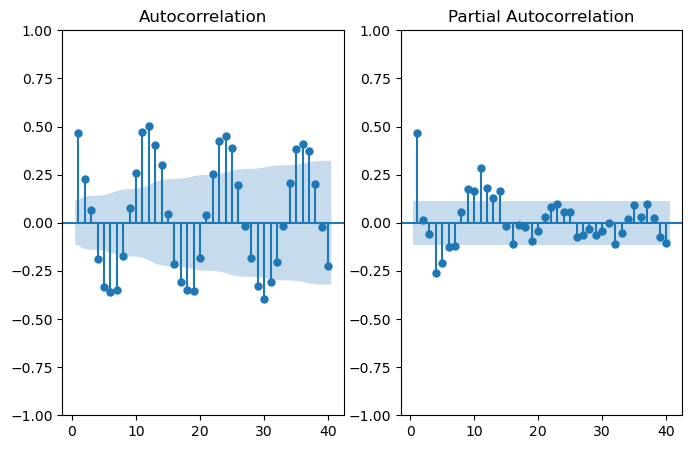

In [8]:
tsa.plot_acf_pacf(diff=0, wantSeasonal=False,wantOberved=False,wantNoSeasonal=False, whatSeasonal='')

Parece que existe una estacionalidad, creo que esta en 6 y 12 meses

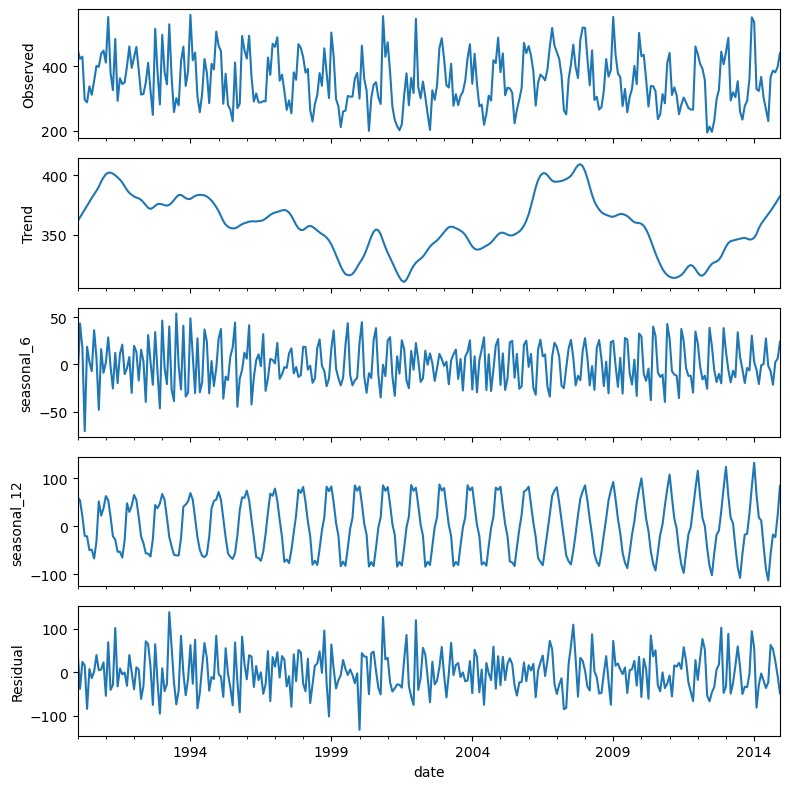

In [9]:
fig, res2 = tsa.stl_decomposition(periods_seasonality=(6, 12))

Ahora estoy casi seguro

### Descomponer la serie de tiempo en las componentes estaciones detectadas.

<AxesSubplot:xlabel='date'>

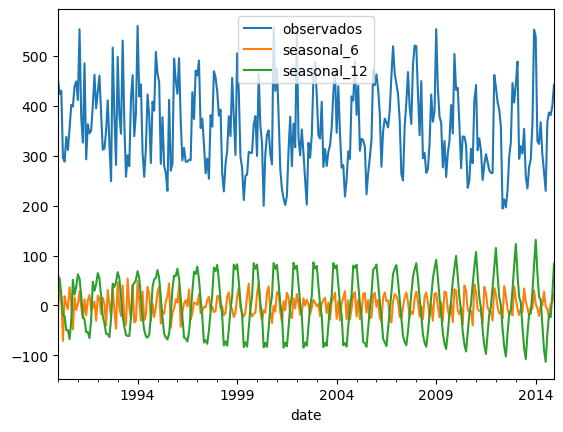

In [10]:
# Graficar datos observados con datos de estacionalidad
ax = res2.observed.to_frame('observados')[:400].plot()

res2.seasonal[:400].plot(ax=ax)

veamos si pasan la prueba

In [11]:
tsa.adf_test(diff=0,wantSeasonal=True,wantOberved=False,wantNoSeasonal = False,whatSeasonal='seasonal_12')

Results of Dickey-Fuller Test:
Test Statistic                 -35.110082
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary


In [12]:
tsa.adf_test(diff=0,wantSeasonal=True, wantOberved=False,wantNoSeasonal = False,whatSeasonal='seasonal_6')

Results of Dickey-Fuller Test:
Test Statistic                -9.741365e+00
p-value                        8.478448e-17
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary


Las dos son estacionarias

### Determinar parámetros $(P,D,Q,S)$ 

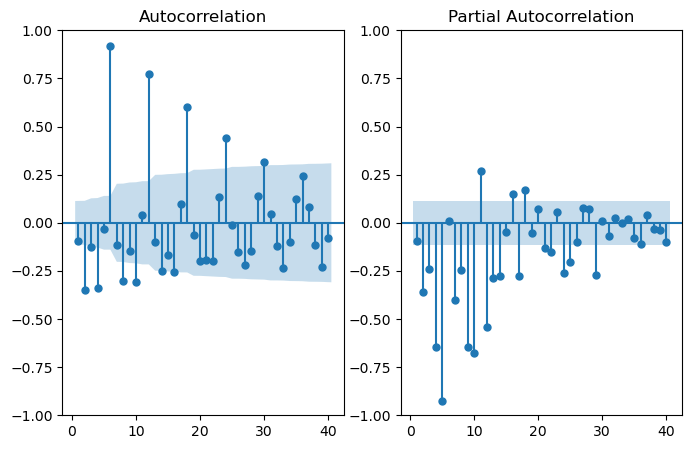

In [13]:
# Graficar ACF y PACF - > Analizar el caso cuando se diferencia la serie estacional seleccionada
tsa.plot_acf_pacf(diff=0, wantSeasonal=True,wantOberved=False,wantNoSeasonal=False, whatSeasonal='seasonal_6')

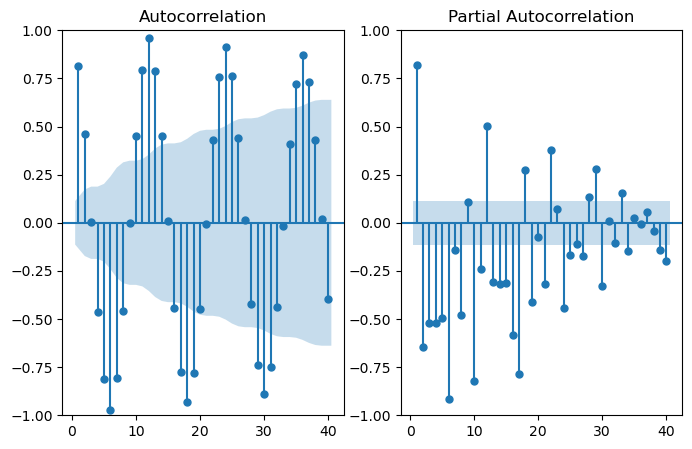

In [14]:
tsa.plot_acf_pacf(diff=0, wantSeasonal=True,wantOberved=False, wantNoSeasonal=False,whatSeasonal='seasonal_12')

Parece que tenemos         
* P(0, 1, 2, 3, 4, 5)     
* D(0)
* Q(0, 1, 2)

### Componente no estacional $(p, d, q)$

In [15]:
tsa.adf_test(diff=0,wantSeasonal=True, wantOberved=True,wantNoSeasonal = False, whatSeasonal='')

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


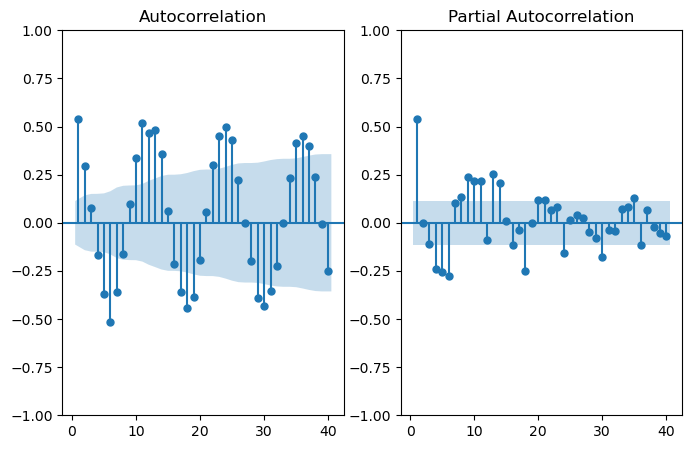

In [16]:
tsa.plot_acf_pacf(diff=0, wantSeasonal=True,wantOberved=True,wantNoSeasonal=False, whatSeasonal='seasonal_6')

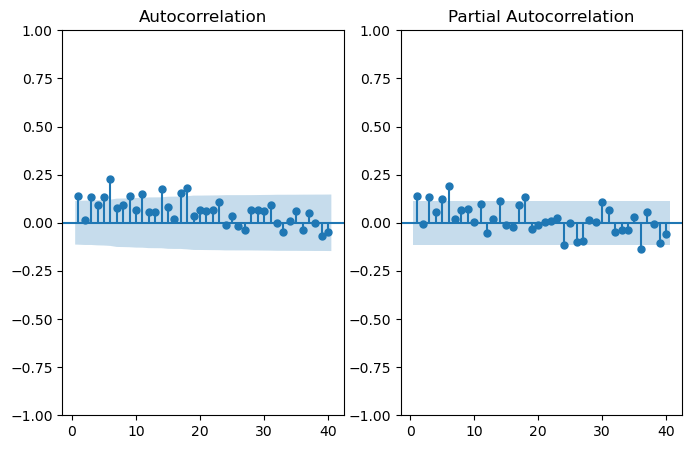

In [17]:
tsa.plot_acf_pacf(diff=0, wantSeasonal=True,wantOberved=True,wantNoSeasonal=False, whatSeasonal='seasonal_12')

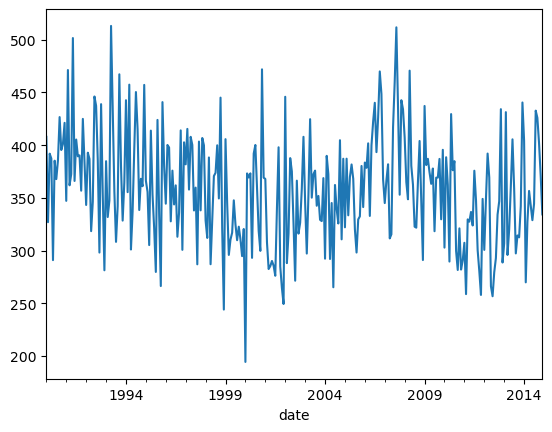

In [18]:
non_seasonal2 = res2.observed - res2.seasonal['seasonal_6'] - res2.seasonal['seasonal_12']

ax = non_seasonal2.plot()

plt.show()

In [19]:
tsa.adf_test(diff=1,wantSeasonal=True, wantOberved=True,wantNoSeasonal = True, whatSeasonal='')

Results of Dickey-Fuller Test:
Test Statistic                -5.958388e+00
p-value                        2.066936e-07
#Lags Used                     1.600000e+01
Number of Observations Used    2.820000e+02
Critical Value (1%)           -3.453754e+00
Critical Value (5%)           -2.871844e+00
Critical Value (10%)          -2.572261e+00
dtype: float64
Stationary


Los dos juntos

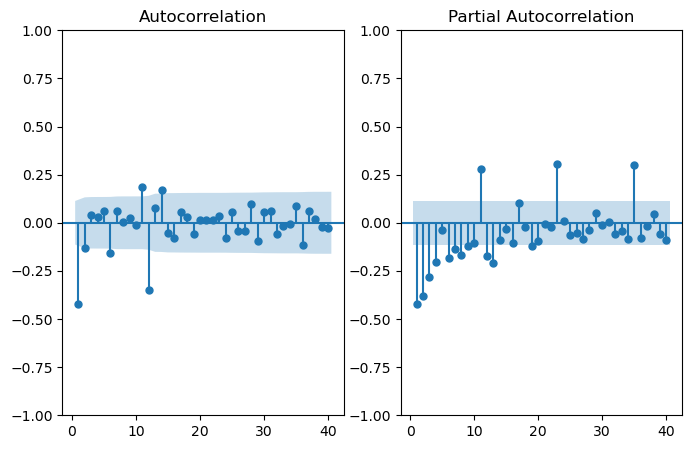

In [20]:
tsa.plot_acf_pacf(diff=1, wantSeasonal=True,wantOberved=True,wantNoSeasonal=True, whatSeasonal='')

Parece que tenemos
* p(0,1,2,3)
* d(0,1)
* q(0,1,2)

### Escalemos

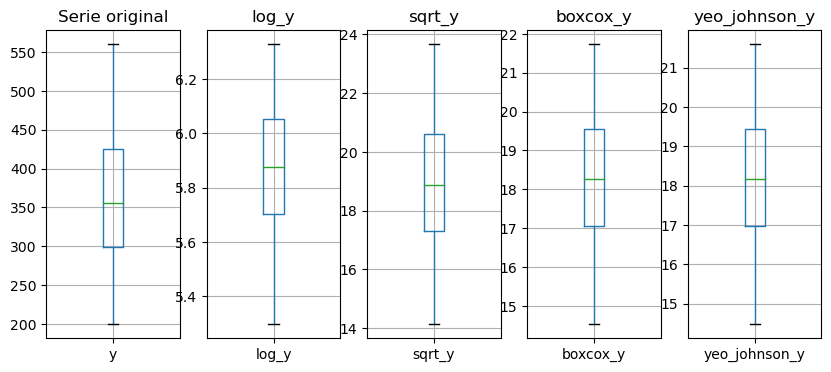

In [21]:
y_train, y_test, fig =tsa.split_and_transform()

### Eligiremos la boxcox_y

In [22]:
y_train

,y,log_y,sqrt_y,boxcox_y,yeo_johnson_y
date,,,,,
1990-01-31,451.887005,6.113432,21.257634,20.022905,19.903733
1990-02-28,423.897505,6.049492,20.588771,19.537375,19.423905
1990-03-31,430.298776,6.064480,20.743644,19.650260,19.535465
1990-04-30,296.197605,5.691027,17.210392,16.998973,16.915342
1990-05-31,288.352006,5.664182,16.980931,16.820806,16.739281
...,...,...,...,...,...
2009-08-31,305.111702,5.720678,17.467447,17.197626,17.111651
2009-09-30,330.127065,5.799478,18.169399,17.735204,17.642897
2009-10-31,401.772201,5.995885,20.044256,19.138216,19.029432


### Malla de parametros

In [23]:
sarimax_params = TimeSeriesAnalyzer.generate_sarimax_params(p=[0, 1,2,3], d=[0,1], q=[0, 1,2], 
                                                         P=[0, 1, 2,3,4,5], D=[0], Q=[0, 1, 2], 
                                                         t=['n', 'c', 't', 'ct'], seasonal_period=6)

### Con los datos escalados encontrar el conjunto más adecuado de parámetros

In [24]:
evaluated =tsa.evaluate_sarimax_params(sarimax_params,'log_y')

In [25]:
evaluated.sort_values(by=['AIC'], ascending=True)

,params,AIC,BIC,LLF
13,"((0, 0, 2), (5, 0, 2, 6), 'c')",-112.463393,-74.176365,67.231697
1,"((0, 0, 2), (4, 0, 2, 6), 'c')",-101.851522,-67.045133,60.925761
0,"((0, 0, 2), (4, 0, 2, 6), 'n')",-78.284302,-46.958551,48.142151
9,"((0, 0, 2), (5, 0, 1, 6), 'c')",-46.069463,-11.263073,33.034731
12,"((0, 0, 2), (5, 0, 2, 6), 'n')",-45.852808,-11.046419,32.926404
8,"((0, 0, 2), (5, 0, 1, 6), 'n')",-44.006725,-12.680975,31.003362
4,"((0, 0, 2), (5, 0, 0, 6), 'n')",-39.530908,-11.685797,27.765454
3,"((0, 0, 2), (4, 0, 2, 6), 'ct')",-28.72808,9.558948,25.36404
6,"((0, 0, 2), (5, 0, 0, 6), 't')",-28.69429,2.63146,23.347145
10,"((0, 0, 2), (5, 0, 1, 6), 't')",-25.539346,9.267043,22.769673


## MODELO

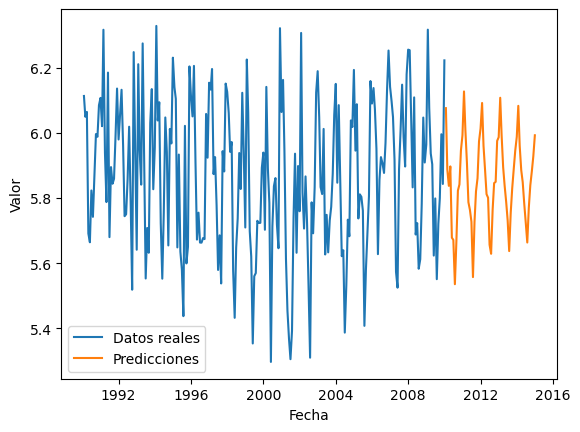

In [26]:
mae, mse = tsa.fit_predict_evaluate_plot(order=(0, 0, 2), seasonal_order=(5, 0, 2, 6), trend='c')

In [27]:
mae, mse

(331.0427041798197, 116188.2876434405)

### Respuesta planteada en el ejercicio usando (markdown)
 La respuesta es .........